In [ ]:
import librosa
import numpy as np
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
import tensorflow.keras.layers as layers
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import librosa.display
import pylab

In [ ]:
ragas=os.listdir('/content/drive/MyDrive/Audio_Data_BatchOne_TenRagas/')

In [ ]:
ragas

['Atana',
 'Husseni',
 'Bilahari',
 'Behag',
 'Bhairavi',
 'Begada',
 'Harikambhoji',
 'Dhanyasi',
 'Kamas',
 'Kalyani',
 '.ipynb_checkpoints']

In [ ]:
from librosa.feature import melspectrogram

path = '/content/drive/MyDrive/Audio_data_batch_two_tenragas/Kamas'
music=os.listdir(path)
for name in music:
     vocals=path+'/'+name
     songname=vocals
     filename=name
     y, sr = librosa.load(songname, mono=True)
     dur = librosa.get_duration(y=y, sr=sr)
     off=0

     if dur > 300:
        for i in range(60):
          x, sr = librosa.load(songname, mono=True,offset=off,duration=5)
          pylab.axis('off') # no axis
          pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
          S = librosa.feature.melspectrogram(y=x, sr=sr)
          librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
          pylab.savefig(f'/content/drive/MyDrive/mel_spect_images2/Kamas/Kamas.{filename.replace(".", "")}.png', bbox_inches=None, pad_inches=0)
          pylab.close()
          filename = name+'-'+str(i+1)
          print(filename+" "+ "added" + 'dur '+str(dur))
          if i in range(0,18):
            off=off+5
          if i in range(18,42):
            off=(dur/60)*i
          if i in range(42,60):
            off= dur - ((60-i)*5)

     else:
        for i in range(60):
          x, sr = librosa.load(songname, mono=True,offset=off,duration=(dur/60))
          pylab.axis('off') # no axis
          pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
          S = librosa.feature.melspectrogram(y=x, sr=sr)
          librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
          pylab.savefig(f'/content/drive/MyDrive/mel_spect_images2/Kamas/Kamas.{filename.replace(".", "")}.png', bbox_inches=None, pad_inches=0)
          pylab.close()
          filename = name+'-'+str(i+1)
          print(filename+" "+ "added(small)"+'dur '+str(dur))
          off=(dur/60)*(i)


In [ ]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.1,
                                             directory= os.path.join('/content/drive/MyDrive/splitdata_three/train'),
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.1,
                                             directory= os.path.join('/content/drive/MyDrive/splitdata_three/train'),
                                             shuffle=False,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

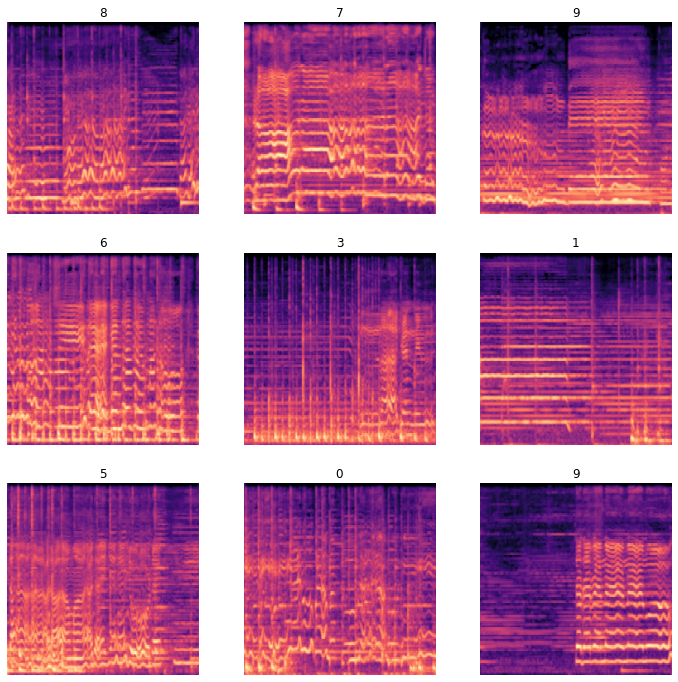

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [ ]:
def prepare(ds, augment=False):
    
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
   
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             directory= os.path.join('/content/drive/MyDrive/splitdata_three/val'),
                                             color_mode='rgb',
                                             image_size=(256, 256),
                                             batch_size=BATCH_SIZE,
                                             shuffle = False ,
                                             seed=0)

In [ ]:
def preparetest(ds, augment=False):
   
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    
    return ds

test_dataset = preparetest(test_dataset, augment=False)

In [ ]:
y = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(256, 256, 10)))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                      

In [ ]:
# Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20, callbacks = early_stopping_callback)

Epoch 1/20
171/171 [==============================] - 1173s 6s/step - loss: 2.5421 - accuracy: 0.1714 - val_loss: 3.5658 - val_accuracy: 0.0000e+00
Epoch 2/20
171/171 [==============================] - 44s 248ms/step - loss: 1.9185 - accuracy: 0.3376 - val_loss: 5.0680 - val_accuracy: 0.0000e+00
Epoch 3/20
171/171 [==============================] - 43s 247ms/step - loss: 1.6253 - accuracy: 0.4460 - val_loss: 2.9367 - val_accuracy: 0.0000e+00
Epoch 4/20
171/171 [==============================] - 44s 252ms/step - loss: 0.9380 - accuracy: 0.7122 - val_loss: 1.8378 - val_accuracy: 0.2268
Epoch 5/20
171/171 [==============================] - 43s 247ms/step - loss: 0.5327 - accuracy: 0.8543 - val_loss: 0.2601 - val_accuracy: 0.9305
Epoch 6/20
171/171 [==============================] - 44s 249ms/step - loss: 0.2708 - accuracy: 0.9355 - val_loss: 0.1559 - val_accuracy: 0.9685
Epoch 7/20
171/171 [==============================] - 44s 249ms/step - loss: 0.1205 - accuracy: 0.9770 - val_loss: 0.30

Testing

In [ ]:
preds = model.predict(test_dataset)
predclasses = tf.math.argmax(input = preds, axis= 1)

In [ ]:
np.save('/content/drive/MyDrive/img_preds2.npy', preds)
np.save('/content/drive/MyDrive/img_testset2.npy', y)

In [ ]:
Y_pred = np.load('/content/drive/MyDrive/img_preds2.npy')
Y_test = np.load('/content/drive/MyDrive/img_testset2.npy')

In [ ]:
import pandas as pd
Y_pred = tf.math.argmax(Y_pred, axis=1)
Y_pred = pd.DataFrame(Y_pred)
Y_test = pd.DataFrame(Y_test)
Y_pred.columns = ['predicted']
Y_test.columns = ['true']

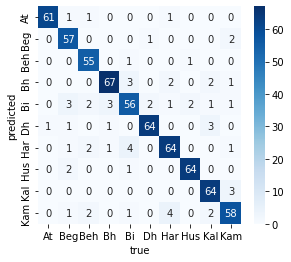

In [ ]:
cm_2Dcnn = pd.crosstab(Y_pred['predicted'], Y_test['true'])
import seaborn as sn
fig = plt.figure(figsize = (10, 4))
ax1 = plt.subplot(121)
sn.heatmap(cm_2Dcnn, annot= True, cmap= 'Blues')